In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score
sns.set_style("darkgrid")
from geopy.distance import vincenty

In [5]:
readings.head()

,Date,Virus,Month,Year,DayRunner,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot
0,2007-05-29,0,5,2007,149,0,0,1,0,5,3
1,2007-05-29,0,5,2007,149,0,0,0,1,5,3
2,2007-05-29,0,5,2007,149,0,0,0,1,3,2
3,2007-05-29,0,5,2007,149,0,0,1,0,5,3
4,2007-05-29,0,5,2007,149,0,0,0,1,5,3


In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

# Read and Split the Data

In [21]:
weather=pd.read_csv('weather2.csv')
readings=pd.read_csv('readings.csv')
test=pd.read_csv('test.csv')
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [23]:
weather.head()

,Date,avg_rain1,avg_rain2,avg_dry1,avg_dry2
0,2007-05-01,NaN,NaN,NaN,NaN
1,2007-05-02,0.00,NaN,1.000000,NaN
2,2007-05-03,0.00,NaN,0.500000,NaN
3,2007-05-04,0.00,NaN,0.666667,NaN
4,2007-05-05,0.25,NaN,0.750000,NaN


In [30]:
chicago2=pd.merge(readings, weather, on='Date').drop(['Date', 'Month', 'Year'], axis=1);
chicago=pd.merge(test, weather, on='Date')
print(chicago.shape, chicago.shape, chicago2.columns)
chicago['DayRunner']=pd.to_datetime(chicago['Date']).dt.dayofyear
chicago = chicago.drop(['Date'], axis=1)
chicago.head()


(116293, 15) (116293, 15) Index(['Virus', 'DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS',
       'RESTUANS', 'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2',
       'avg_dry1', 'avg_dry2'],
      dtype='object')


,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,avg_rain1,avg_rain2,avg_dry1,avg_dry2,DayRunner
0,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286,163
1,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286,163
2,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286,163
3,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286,163
4,5,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,0.571429,0.142857,0.714286,163


In [8]:
# Split the data
# X = chicago.drop(['Virus'], axis=1)
# y = chicago['Virus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
X_train.shape # Notice the number of rows in the training set. This should stay constant.

(8404, 11)

In [39]:
X = chicago
X_build = chicago2.drop(['Virus'], axis=1)
y = chicago2['Virus']

X_train, X_test, y_train, y_test = train_test_split(X_build, y, test_size = .2, random_state=42)

print(X.columns)
print(len(X_train.columns))
X_train.columns

Index(['Id', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'avg_rain1', 'avg_rain2', 'avg_dry1', 'avg_dry2', 'DayRunner', 'CULEX',
       'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS'],
      dtype='object')
11


Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')

In [40]:
chicago['CULEX']='ALTER'
chicago.loc[(chicago['Species']=='CULEX PIPIENS/RESTUANS') , 'CULEX']='PIPIENS-RESTUANS'
chicago.loc[(chicago['Species']=='CULEX RESTUANS') , 'CULEX']='RESTUANS'
chicago.loc[(chicago['Species']=='CULEX PIPIENS') , 'CULEX']='PIPIENS'
chicago['CULEX'].value_counts()
# Dummify the Species
dummies=pd.get_dummies(chicago['CULEX'])
chicago=pd.concat([chicago, dummies], axis=1)

In [49]:
import pickle
from tqdm import tqdm

with open('top_hots.pickle', 'rb') as f:
    top_hots = pickle.load(f)

chicago['lat_long'] = list(zip(chicago['Latitude'], chicago['Longitude']))
latlongs=chicago.groupby('lat_long').mean()

# For each trap, let's calculate its distance from the top virus hotspots
for x in tqdm(range(30)):
    digit=str(x)
    chicago['to_hotspot'+digit]=chicago['lat_long'].apply(lambda row: vincenty(row, top_hots[x]).miles)
    
    # Create an indicator if a row is less than 2 miles from one of the virus hotspots
    chicago['flag_hotspot'+digit]=chicago['to_hotspot'+digit].apply(lambda row: row<2).astype(int)
    
# Summarize those indicators.
hot_list=['flag_hotspot0',
          'flag_hotspot1',
          'flag_hotspot2',
          'flag_hotspot3',
          'flag_hotspot4',
          'flag_hotspot6',
          'flag_hotspot6',
          'flag_hotspot7',
          'flag_hotspot8',
          'flag_hotspot9',
          'flag_hotspot10',
          'flag_hotspot11',
          'flag_hotspot12',
          'flag_hotspot13',
          'flag_hotspot14',
          'flag_hotspot16',
          'flag_hotspot16',
          'flag_hotspot17',
          'flag_hotspot18',
          'flag_hotspot19',
          'flag_hotspot20',
          'flag_hotspot21',
          'flag_hotspot22',
          'flag_hotspot23',
          'flag_hotspot24',
          'flag_hotspot26',
          'flag_hotspot26',
          'flag_hotspot27',
          'flag_hotspot28',
          'flag_hotspot29',
         ]
chicago['near_hotspot'] = chicago[hot_list].sum(axis=1)
chicago['near_hotspot'].describe()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:13<00:00,  4.43s/it]


count    116293.000000
mean          1.661158
std           1.851068
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max           8.000000
Name: near_hotspot, dtype: float64

In [50]:
print(X_train.columns)
chicago.head(1)

Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')


,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,flag_hotspot25,to_hotspot26,flag_hotspot26,to_hotspot27,flag_hotspot27,to_hotspot28,flag_hotspot28,to_hotspot29,flag_hotspot29,near_hotspot
0,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,1,13.244228,0,24.486302,0,12.310611,0,6.144767,0,5


In [53]:
with open('top_chomps.pickle', 'rb') as f:
    top_chomps = pickle.load(f)

# Do the same thing for its distance from the 20 spots with highest average mosquito count.
for x in tqdm(range(30)):
    digit=str(x)
    chicago['to_chompspot'+digit]=chicago['lat_long'].apply(lambda row: vincenty(row, top_chomps[x]).miles)   

    # Create an indicator if a row is less than 2 miles from one of the high-mosquito-count chompspots
    chicago['flag_chompspot'+digit]=chicago['to_chompspot'+digit].apply(lambda row: row<2).astype(int)
    
# Summarize those 10 indicators.
chomp_list=['flag_chompspot0',
          'flag_chompspot1',
          'flag_chompspot2',
          'flag_chompspot3',
          'flag_chompspot4',
          'flag_chompspot6',
          'flag_chompspot6',
          'flag_chompspot7',
          'flag_chompspot8',
          'flag_chompspot9',
          'flag_chompspot10',
          'flag_chompspot11',
          'flag_chompspot12',
          'flag_chompspot13',
          'flag_chompspot14',
          'flag_chompspot16',
          'flag_chompspot16',
          'flag_chompspot17',
          'flag_chompspot18',
          'flag_chompspot19',
          'flag_chompspot20',
          'flag_chompspot21',
          'flag_chompspot22',
          'flag_chompspot23',
          'flag_chompspot24',
          'flag_chompspot26',
          'flag_chompspot26',
          'flag_chompspot27',
          'flag_chompspot28',
          'flag_chompspot29',
         ]
chicago['near_chompspot'] = chicago[chomp_list].sum(axis=1)
chicago['near_chompspot'].describe()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:17<00:00,  4.58s/it]


count    116293.000000
mean          1.192221
std           1.321861
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: near_chompspot, dtype: float64

In [54]:
print(X_train.columns)
chicago.head(1)

Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')


,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,flag_chompspot25,to_chompspot26,flag_chompspot26,to_chompspot27,flag_chompspot27,to_chompspot28,flag_chompspot28,to_chompspot29,flag_chompspot29,near_chompspot
0,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,0,17.179444,0,9.684294,0,1.265442,1,13.605184,0,3


In [55]:
drop_list=[]
for x in range(30):
    digit=str(x)
    drop_list.append('to_hotspot'+digit)
    drop_list.append('flag_hotspot'+digit)
    drop_list.append('to_chompspot'+digit)
    drop_list.append('flag_chompspot'+digit)
# Drop them becuase they are no longer necessary.
chicago=chicago.drop(hot_list + chomp_list + drop_list, axis=1)

In [63]:
print(X_train.columns)
whoops = chicago.drop(['Id','Latitude',
              'Longitude', 'Street', 'Block', 'Trap', 'Address', 
              'AddressAccuracy','AddressNumberAndStreet', 'Date',
              'Species', 'CULEX', 'lat_long'], axis=1)[['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2']]

Index(['DayRunner', 'ALTER', 'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS',
       'near_hotspot', 'near_chompspot', 'avg_rain1', 'avg_rain2', 'avg_dry1',
       'avg_dry2'],
      dtype='object')


In [66]:
chicago = whoops.loc[:,~whoops.columns.duplicated()]

array([[2.67000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        1.42857143e-01, 8.57142857e-01, 8.57142857e-01],
       [2.06000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        2.85714286e-01, 7.14285714e-01, 7.14285714e-01],
       [1.68000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        5.71428571e-01, 4.28571429e-01, 4.28571429e-01],
       ...,
       [2.25000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        2.85714286e-01, 2.85714286e-01, 5.71428571e-01],
       [2.13000000e+02, 0.00000000e+00, 1.00000000e+00, ...,
        1.42857143e-01, 5.71428571e-01, 7.14285714e-01],
       [2.24000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        2.85714286e-01, 2.85714286e-01, 1.42857143e-01]])

In [71]:
import tensorflow as tensor
import keras
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
%matplotlib inline

sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test.values)
X_holdout = sc.transform(chicago.values)

X_train.shape, X_test.shape, X_holdout.shape

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


((8404, 11), (2102, 11), (116293, 11))

In [168]:
model = Sequential()
model.add(Dense(output_dim = 40,init ='uniform',activation = 'relu',input_dim=11))

model.add(Dense(100, activation = 'sigmoid'))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.25, noise_shape=None, seed=None))
model.add(Dense(100, activation = 'relu'))

model.add(Dense(activation="softmax", input_dim=20, units=2, kernel_initializer="uniform"))
model.compile(loss='binary_crossentropy', optimizer='adam')

history = model.fit(X_train, to_categorical(y_train), 
            validation_data=(X_test, to_categorical(y_test)),
            epochs=10,
            batch_size=None,
            verbose = 3)

train_loss = history.history['loss']
test_loss = history.history['val_loss']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=11, units=40, kernel_initializer="uniform")`
  


Train on 8404 samples, validate on 2102 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


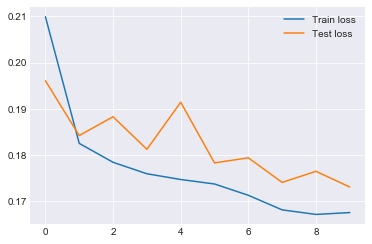

In [169]:
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.legend()

In [170]:
y_pred = model.predict_proba(X_test)
y_pred2 = y_pred[:,1]
print(roc_auc_score(y_test, y_pred2))

0.8107954545454545


In [171]:
y_hat = model.predict_proba(X_holdout)

In [172]:
predictions = pd.DataFrame(y_hat[:,1], columns=['Predicted'])
predictions.describe()

,Predicted
count,116293.000000
mean,0.018903
std,0.043568
min,0.000337
25%,0.000348
50%,0.000363
75%,0.011489
max,0.414156


In [173]:
predictions.to_pickle('predictions_neural')

chicago.to_pickle('test_data_frame')

In [174]:
predictions.head()

,Predicted
0,0.000968
1,0.000828
2,0.001262
3,0.000339
4,0.000339


In [175]:
predictions.index += 1 
predictions.head()

,Predicted
1,0.000968
2,0.000828
3,0.001262
4,0.000339
5,0.000339


In [176]:

predictions.to_csv('Monkey.csv')